In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision as tv
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

import torchvision.datasets as datasets
from pathlib import Path

from torchview import draw_graph

import constants
import dataset
import util
import json
import pandas as pd
import models 
from models import VQANet
import matplotlib.pyplot as plt
import numpy as np
import time
import gc

from transformers import AutoTokenizer
import traceback

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():      
    device = 'mps'                         
else:
    device = torch.device('cpu')


device = torch.device('cpu')
# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)
    



using device: cpu


In [2]:

%load_ext autoreload
%autoreload 2

In [3]:

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [4]:
# with open(constants.CAPTION_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["annotations"][0])

# with open(constants.VQA_OPEN_ENDED_QUESTION_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["questions"][0])

# with open(constants.VQA_OPEN_ENDED_ANSWER_TRAIN, 'r') as f:
#     data = json.load(f)
#     print(data.keys())
#     print(data["annotations"][0])
    
# with open(constants.CAPTION_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

# with open(constants.VQA_OPEN_ENDED_QUESTION_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

# with open(constants.VQA_OPEN_ENDED_ANSWER_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

#dataset.load(constants.VQA_OPEN_ENDED_QUESTION_TRAIN, ['image_id', 'id', 'caption'])

In [35]:
train = dataset.Coco()
val = dataset.Coco("validation")
test = dataset.Coco("test")

Found annotations at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/instances_train2017.json'
Images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Found annotations at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Found test info at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/image_info_test2017.json'
Images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'coco-2017-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [6]:
print(len(train))
print(len(train.captions))

118287
591753


In [7]:
if False: # debug
    img = train.__getitem__(1)
    print(img)
    print(img.image_id)
    print(img.image_path)

    print(">>>>")
    print(img.captions())

    print(">>>>")
    print(img.qa())
    print("shape", img.image_tensor().shape)

    show([img.image_tensor()])

#plt.imshow(  img.image_tensor().permute(1, 2, 0)  )


In [8]:
tokenizer  = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Add the Q and A token as special token
tokenizer.add_special_tokens(constants.QA_TOKEN_DICT)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


4

In [84]:
def collate_fn2(batch):
    result = {}
    
    result['image_ids'] = []
    result['images'] = []
    result['c2i'] = [] # index for images for a given caption. same len as 'caption'
    result['qa2i'] = [] # index of corresponding image for a given qa. same len as 'qa'
    result['q_id'] = [] # id of the questions 'qa'
    result['images']
    
    
    target  = [] # the corresponding target for the qa.
    raw_captions = []  # plain text 
    raw_qa = []   # plain text
    raw_qids = []   # question ids
    for idx, data in enumerate(batch):
        result['image_ids'].append(data.image_id)
        result['images'].append(data.image_tensor())
        caption_list = data.captions()
        if caption_list is not None:
            raw_captions += caption_list
            for c in range(len(caption_list)):
                result['c2i'].append(idx)
        
        qa_list = data.qa()
        q_id_list = data.qids()
        if qa_list is not None:
            raw_qa += qa_list
            raw_qids += q_id_list
            for c in range(len(qa_list)):
                result['qa2i'].append(idx)
    #print("raw_cap", len(raw_captions))
    #print("raw_qa", len(raw_qa))
    
    result['raw_cap'] = raw_captions
    result['captions'] = None if len(raw_captions) == 0 else \
                                tokenizer(raw_captions, padding=True , return_tensors="pt").to(device)
    result['raw_qa'] = raw_qa
    result['qids'] = raw_qids
    if len(raw_qa) != 0:
#        print("raw_qa:", raw_qa)
        result['qa'] =  tokenizer(raw_qa, padding=True , return_tensors="pt")['input_ids'].to(device, dtype=torch.int64)
        end_padding = torch.broadcast_to(torch.zeros(1), (result['qa'].shape[0], 1)).to(device, dtype=torch.int64)
        #print(end_padding.shape)
        # return a shape {seq, batch}
        target = torch.column_stack((result['qa'][:, 1:], end_padding)).transpose(0, 1)
    else:
        result['qa'] = None
        target = None
    return result, target

In [85]:
from torch.utils.data import DataLoader
batch_size = 5
fn = collate_fn2 
shuffle = False  # True
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, collate_fn=fn)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, collate_fn=fn)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, collate_fn=fn)

In [42]:
def spot_check(dataloader, size=5):
    it = iter(dataloader)
    for _ in range(size):
        x, target= next(it)
        print(x)
        show(x["images"])

{'image_ids': [9, 25, 30, 34, 36], 'images': [tensor([[[  2,   1,   1,  ..., 140, 136, 133],
         [  1,   1,   1,  ..., 144, 138, 135],
         [  0,   0,   1,  ..., 142, 139, 137],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[ 23,  22,  23,  ..., 176, 172, 170],
         [ 21,  21,  23,  ..., 179, 175, 173],
         [ 22,  23,  25,  ..., 180, 178, 177],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[110, 111, 114,  ..., 202, 198, 197],
         [111, 112, 115,  ..., 206, 201, 199],
         [113, 112, 115,  ..., 206, 203, 202],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8), tensor([[[  8,   7,   8,  ..., 155, 126,

{'image_ids': [81, 86, 89, 92, 94], 'images': [tensor([[[187, 187, 187,  ..., 174, 175, 174],
         [189, 187, 186,  ..., 174, 175, 175],
         [190, 187, 187,  ..., 174, 175, 175],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[195, 194, 194,  ..., 183, 184, 183],
         [195, 195, 195,  ..., 184, 184, 184],
         [195, 194, 194,  ..., 183, 184, 184],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[199, 200, 198,  ..., 190, 190, 191],
         [198, 198, 198,  ..., 193, 193, 192],
         [198, 198, 197,  ..., 192, 192, 190],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8), tensor([[[196, 211, 236,  ...,   0,   0

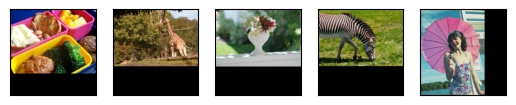

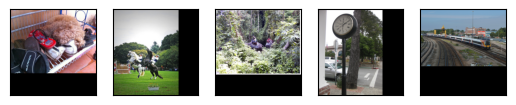

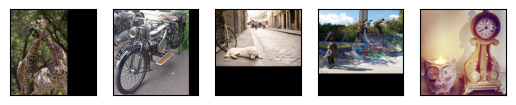

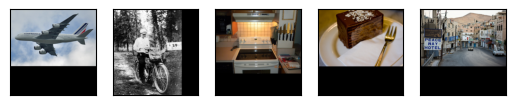

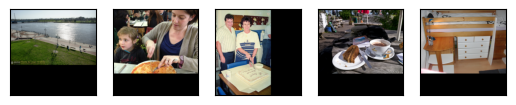

In [43]:
spot_check(train_dataloader)

{'image_ids': [1, 16, 19, 57, 63], 'images': [tensor([[[ 19,  23,  29,  ..., 154, 155, 157],
         [ 20,  20,  25,  ..., 154, 154, 155],
         [ 22,  26,  27,  ..., 154, 154, 155],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[ 25,  28,  39,  ..., 165, 164, 163],
         [ 28,  28,  36,  ..., 165, 165, 164],
         [ 27,  28,  32,  ..., 165, 165, 164],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[ 19,  20,  29,  ..., 160, 161, 162],
         [ 23,  21,  28,  ..., 160, 161, 161],
         [ 23,  23,  25,  ..., 159, 160, 160],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8), tensor([[[ 73,  71,  70,  ...,   0,   0,

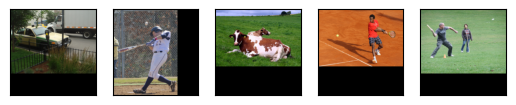

In [13]:
spot_check(test_dataloader)

In [14]:
ce_fn = nn.CrossEntropyLoss( reduction='none')
cos_fn = nn.CosineSimilarity(dim=1)

In [15]:
# out = model(x, device)
# image_embedding, captions_embeddings, output_logits = out
# print(captions_embeddings.shape)
# a = output_logits.reshape(-1, len(tokenizer))
# b = target.reshape(-1)
# print("a", a.shape, a)
# print("b", b.shape, b)

# ce_loss = ce_fn(a, b)
# print(ce_loss.shape)
# N = len(x['images'])
# M = len(x['qa2i'])
# ce = ce_loss.reshape(-1, M).transpose(0, 1)
# print(ce.shape)
# print(ce)
# per_qa  = torch.mean(ce, axis = 1)
# print(per_qa.shape)

In [ ]:
# blown = models.blow_to(image_embedding, result['c2i'])
# print(image_embedding.shape)
# print(image_embedding)
# print(blown.shape)
# print(blown)
# print("captions_embedding:", captions_embeddings.shape)
# print(result['c2i'])

In [17]:
# print(blown)
# print(captions_embeddings)
# cos= nn.CosineSimilarity(dim = 0)
# print(cos(blown[1], captions_embeddings[1]))

# per_caption_loss = cos_fn(blown, captions_embeddings)
# print(per_caption_loss)
# per_image_caption_loss = cal_average(len(result['images']), per_caption_loss, result['c2i'])
# print(per_image_caption_loss.shape)

# print(per_image_caption_loss)

In [127]:
model = VQANet(tokenizer).to(device)
lr = 0.1
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [122]:
def cal_average(size, blown_loss, replicas):
    result= torch.zeros(size).to(device)
    counts = torch.zeros(size).to(device)
    for index, val in enumerate(replicas):
        result[val] += blown_loss[index]
        counts[val] += 1
        
    for index in range(size):
        if counts[index] == 0:
            counts[index] = 1  # so that result / counts still makes sense.
    #print("result", result)
    #print("counts:", counts)
    counts = counts.detach()  # we don't need gradient for the counts.
    result /= counts
    return result

In [129]:
gamma = 0.9
DEBUG = False
def do_train(model, idx, x, target, should_print = False):
        N = len(x['images'])
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        if DEBUG:
            image_embedding_for_captions, captions_embedding, output_logits = None, None, None
        else:
            image_embedding_for_captions, captions_embedding, output_logits  = model(x, device)

#        image_embedding, captions_embedding, output_logits = None, None, None
        per_image_qa_loss = None
        per_image_caption_loss = None
        
        if output_logits is not None:
#            print("out_logits argmax", torch.argmax(output_logits.transpose(0,1), axis=2))
#            print("target", target)
            a = output_logits.reshape(-1, len(tokenizer))

            b = target.reshape(-1)
#            print("a", a.shape)
#            print("b", b.shape)

            K = len(x['qa2i'])
            # back to (K, seq)
            qa_loss = ce_fn(a, b).reshape(-1, K).transpose(0, 1)
            #print("qa_loss", qa_loss.shape)
            # qa loss, shape of (K) (different images can have diff counts of qas)
            per_qa_loss = torch.mean(qa_loss, axis = 1)

            # per image qa loss, shape of (N)
            per_image_qa_loss = cal_average(N, per_qa_loss, x['qa2i'])
            #print("per_qa_loss", per_qa_loss.shape)
            #print("per_image_qa_loss", per_image_qa_loss.shape)

        if captions_embedding is not None:
            # loss per caption, shape of (M) (different images can have diff counts of captions)
            per_caption_loss = cos_fn(image_embedding_for_captions, captions_embedding)
            # cosine similarity is within [-1, 1] where 1 being similar. 
            # for loss, we invert it and shift it by 1 to keep the value always positive.
            # thus 0 means similar, 2 means completely opposite
            # print("per_captions_loss:", per_caption_loss)
            per_caption_loss = -per_caption_loss + 1
            # print("normalized per_captions_loss:", per_caption_loss)
            # per image loss on the caption scale. shape of (N)
            per_image_caption_loss = cal_average(N, per_caption_loss, x['c2i'])

        if should_print:
            print("per_image_caption_loss", per_image_caption_loss)
            print("per_image_qa_loss", per_image_qa_loss)
        total_loss = 0
        if per_image_qa_loss is not None:
            total_loss += gamma * per_image_caption_loss
            
        if per_image_qa_loss is not None:
            total_loss += per_image_qa_loss

        loss = torch.sum(total_loss)

        if not DEBUG:
            loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()


        del per_image_caption_loss
        del per_image_qa_loss
        del x
        del total_loss
        return loss
            
def training(model, writer, epoches, early_terminate = None, empty_catch_after_every_n = 200, print_every = 100):
    start_time = time.time()
    model.train()
    for epoch_idx in range(epoches):
        print ("----- Start Epoch %s -----" % epoch_idx)
        epoch_loss = 0
        for idx, (x, target) in enumerate(train_dataloader):
            should_print = print_every is not None and (print_every == 1 or idx % (print_every -1) == 0)
            if should_print:
                print(">>>> Batch # ", idx,  x['image_ids'] )
            if early_terminate is not None:
                if idx > early_terminate - 1:
                    print("early terminating. at ", idx)
                    break;
            try:
                loss = do_train(model, idx, x, target, should_print).detach()
                batch_loss = loss.item()
            except Exception as e:
                print(">>>> FAILED! Batch # ", idx,  x['image_ids'])
                traceback.print_exc()
                break;

            if empty_catch_after_every_n is not None and (idx + 1) % empty_catch_after_every_n == 0:
                print(">>>empty torch mps cache")
                torch.mps.empty_cache()

            if should_print:
                print("loss:", batch_loss)
                print("--- %s Per batch time ---" % (time.time() - start_time))
                
            epoch_loss += batch_loss

        epoch_loss /= len(train_dataloader) if early_terminate is None \
                                            else (early_terminate * train_dataloader.batch_size)
        writer.add_scalar("Loss/train", epoch_loss, epoch_idx)

        print(f"---DONE: {epoch_idx} epoch, {(time.time() - start_time)} seconds, loss {epoch_loss} ---")
    

In [136]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

#training(model, writer, 5, empty_catch_after_every_n=None, early_terminate = 10)
training(model, writer, 10, empty_catch_after_every_n=None, early_terminate = 10)
#training(model, writer, 2, empty_catch_after_every_n=None)
writer.flush()


----- Start Epoch 0 -----
>>>> Batch #  0 [9, 25, 30, 34, 36]
per_captions_loss: tensor([0.5669, 0.5906, 0.5836, 0.5847, 0.5809, 0.6294, 0.6357, 0.6048, 0.6283,
        0.5978, 0.6006, 0.6193, 0.6361, 0.6060, 0.6149, 0.5693, 0.5366, 0.5786,
        0.5689, 0.5775, 0.5203, 0.5625, 0.5698, 0.5627, 0.5538],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.4331, 0.4094, 0.4164, 0.4153, 0.4191, 0.3706, 0.3643, 0.3952, 0.3717,
        0.4022, 0.3994, 0.3807, 0.3639, 0.3940, 0.3851, 0.4307, 0.4634, 0.4214,
        0.4311, 0.4225, 0.4797, 0.4375, 0.4302, 0.4373, 0.4462],
       grad_fn=<AddBackward0>)
per_image_caption_loss tensor([0.4187, 0.3808, 0.3846, 0.4338, 0.4462], grad_fn=<DivBackward0>)
per_image_qa_loss tensor([2.2426, 1.9509, 1.8630, 1.3472, 1.9500], grad_fn=<DivBackward0>)
loss: 11.211359024047852
--- 2.1709258556365967 Per batch time ---
per_captions_loss: tensor([0.6266, 0.6324, 0.6137, 0.6381, 0.6249, 0.6112, 0.6040, 0.6272, 0.6142,
        0.6210, 0.5152, 

per_captions_loss: tensor([0.6343, 0.6130, 0.6384, 0.6282, 0.6221, 0.4858, 0.5779, 0.5490, 0.5712,
        0.5618, 0.6305, 0.6092, 0.5975, 0.5804, 0.6159, 0.6055, 0.5843, 0.5900,
        0.6018, 0.5315, 0.6303, 0.6408, 0.6126, 0.6418, 0.6401],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3657, 0.3870, 0.3616, 0.3718, 0.3779, 0.5142, 0.4221, 0.4510, 0.4288,
        0.4382, 0.3695, 0.3908, 0.4025, 0.4196, 0.3841, 0.3945, 0.4157, 0.4100,
        0.3982, 0.4685, 0.3697, 0.3592, 0.3874, 0.3582, 0.3599],
       grad_fn=<AddBackward0>)
per_captions_loss: tensor([0.6505, 0.6433, 0.6249, 0.6457, 0.4587, 0.5118, 0.5674, 0.5906, 0.4642,
        0.6001, 0.5770, 0.5675, 0.5656, 0.5508, 0.5683, 0.6322, 0.6363, 0.6491,
        0.6460, 0.6582, 0.5554, 0.5533, 0.5329, 0.5613, 0.5677],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3495, 0.3567, 0.3751, 0.3543, 0.5413, 0.4882, 0.4326, 0.4094, 0.5358,
        0.3999, 0.4230, 0.4325, 0.4344, 0.4492, 0.4317

per_captions_loss: tensor([0.6343, 0.6241, 0.6436, 0.6598, 0.6275, 0.4764, 0.5405, 0.5443, 0.5262,
        0.5332, 0.5893, 0.5869, 0.6078, 0.5885, 0.6072, 0.6549, 0.6624, 0.5478,
        0.6427, 0.6439, 0.5823, 0.5988, 0.5866, 0.5646, 0.5943],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3657, 0.3759, 0.3564, 0.3402, 0.3725, 0.5236, 0.4595, 0.4557, 0.4738,
        0.4668, 0.4107, 0.4131, 0.3922, 0.4115, 0.3928, 0.3451, 0.3376, 0.4522,
        0.3573, 0.3561, 0.4177, 0.4012, 0.4134, 0.4354, 0.4057],
       grad_fn=<AddBackward0>)
per_captions_loss: tensor([0.5135, 0.5233, 0.5038, 0.5268, 0.5052, 0.6520, 0.6549, 0.5632, 0.6565,
        0.6432, 0.4770, 0.6534, 0.6304, 0.6308, 0.6262, 0.6025, 0.6219, 0.6083,
        0.6403, 0.6009, 0.5686, 0.5512, 0.5722, 0.5548, 0.5608],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.4865, 0.4767, 0.4962, 0.4732, 0.4948, 0.3480, 0.3451, 0.4368, 0.3435,
        0.3568, 0.5230, 0.3466, 0.3696, 0.3692, 0.3738

per_captions_loss: tensor([0.5969, 0.5861, 0.5881, 0.5677, 0.5971, 0.6425, 0.6555, 0.6349, 0.6617,
        0.6424, 0.6304, 0.6340, 0.6450, 0.6263, 0.6455, 0.6043, 0.6029, 0.6015,
        0.6007, 0.5757, 0.5831, 0.5885, 0.3742, 0.5898, 0.6049],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.4031, 0.4139, 0.4119, 0.4323, 0.4029, 0.3575, 0.3445, 0.3651, 0.3383,
        0.3576, 0.3696, 0.3660, 0.3550, 0.3737, 0.3545, 0.3957, 0.3971, 0.3985,
        0.3993, 0.4243, 0.4169, 0.4115, 0.6258, 0.4102, 0.3951],
       grad_fn=<AddBackward0>)
per_captions_loss: tensor([0.5469, 0.5721, 0.5879, 0.5849, 0.5758, 0.5733, 0.5735, 0.5731, 0.5775,
        0.5113, 0.5778, 0.6047, 0.6021, 0.5843, 0.6127, 0.5716, 0.5566, 0.5387,
        0.5774, 0.5639, 0.6190, 0.6424, 0.6288, 0.6092, 0.6442],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.4531, 0.4279, 0.4121, 0.4151, 0.4242, 0.4267, 0.4265, 0.4269, 0.4225,
        0.4887, 0.4222, 0.3953, 0.3979, 0.4157, 0.3873

per_captions_loss: tensor([0.6484, 0.6024, 0.6051, 0.6276, 0.6429, 0.6299, 0.6401, 0.6369, 0.6083,
        0.6354, 0.6458, 0.6179, 0.6449, 0.6435, 0.6161, 0.5903, 0.6535, 0.4709,
        0.6182, 0.6237, 0.5825, 0.5959, 0.5745, 0.6185, 0.6106],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3516, 0.3976, 0.3949, 0.3724, 0.3571, 0.3701, 0.3599, 0.3631, 0.3917,
        0.3646, 0.3542, 0.3821, 0.3551, 0.3565, 0.3839, 0.4097, 0.3465, 0.5291,
        0.3818, 0.3763, 0.4175, 0.4041, 0.4255, 0.3815, 0.3894],
       grad_fn=<AddBackward0>)
per_captions_loss: tensor([0.6531, 0.4931, 0.6534, 0.6369, 0.6347, 0.5663, 0.5692, 0.5844, 0.5547,
        0.5888, 0.5365, 0.6628, 0.6472, 0.6636, 0.6533, 0.6110, 0.5999, 0.5998,
        0.5891, 0.5860, 0.6255, 0.6569, 0.6484, 0.6506, 0.6182],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3469, 0.5069, 0.3466, 0.3631, 0.3653, 0.4337, 0.4308, 0.4156, 0.4453,
        0.4112, 0.4635, 0.3372, 0.3528, 0.3364, 0.3467

per_captions_loss: tensor([0.6052, 0.5907, 0.5931, 0.6097, 0.5866, 0.6172, 0.6293, 0.6108, 0.6026,
        0.6159, 0.5885, 0.5934, 0.6134, 0.6081, 0.6293, 0.5842, 0.5925, 0.5790,
        0.5913, 0.5988, 0.5398, 0.6030, 0.5898, 0.5684, 0.5653],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3948, 0.4093, 0.4069, 0.3903, 0.4134, 0.3828, 0.3707, 0.3892, 0.3974,
        0.3841, 0.4115, 0.4066, 0.3866, 0.3919, 0.3707, 0.4158, 0.4075, 0.4210,
        0.4087, 0.4012, 0.4602, 0.3970, 0.4102, 0.4316, 0.4347],
       grad_fn=<AddBackward0>)
per_image_caption_loss tensor([0.4029, 0.3848, 0.3935, 0.4108, 0.4268], grad_fn=<DivBackward0>)
per_image_qa_loss tensor([1.2535, 1.4123, 1.3094, 0.8098, 1.1150], grad_fn=<DivBackward0>)
loss: 7.716914176940918
--- 126.98708081245422 Per batch time ---
per_captions_loss: tensor([0.6325, 0.6392, 0.6334, 0.6261, 0.6594, 0.6261, 0.6008, 0.6231, 0.6088,
        0.6333, 0.6247, 0.6411, 0.6250, 0.6293, 0.6394, 0.6371, 0.6079, 0.5973,
       

per_captions_loss: tensor([0.6272, 0.6211, 0.6491, 0.6358, 0.6270, 0.5521, 0.6032, 0.5648, 0.5893,
        0.5932, 0.4805, 0.6222, 0.6141, 0.5278, 0.5564, 0.5727, 0.5475, 0.6067,
        0.6111, 0.6002, 0.6607, 0.6560, 0.6483, 0.6525, 0.6622],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3728, 0.3789, 0.3509, 0.3642, 0.3730, 0.4479, 0.3968, 0.4352, 0.4107,
        0.4068, 0.5195, 0.3778, 0.3859, 0.4722, 0.4436, 0.4273, 0.4525, 0.3933,
        0.3889, 0.3998, 0.3393, 0.3440, 0.3517, 0.3475, 0.3378],
       grad_fn=<AddBackward0>)
per_captions_loss: tensor([0.6703, 0.6371, 0.6587, 0.6565, 0.6430, 0.6028, 0.6057, 0.6033, 0.5406,
        0.6086, 0.6066, 0.5921, 0.5999, 0.5660, 0.5745, 0.6448, 0.6634, 0.6678,
        0.6476, 0.6526, 0.5642, 0.5722, 0.5120, 0.5687, 0.5800],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3297, 0.3629, 0.3413, 0.3435, 0.3570, 0.3972, 0.3943, 0.3967, 0.4594,
        0.3914, 0.3934, 0.4079, 0.4001, 0.4340, 0.4255

per_captions_loss: tensor([0.6599, 0.6396, 0.6509, 0.6806, 0.6750, 0.5927, 0.6031, 0.5957, 0.5760,
        0.5931, 0.6299, 0.6292, 0.6260, 0.6264, 0.6335, 0.6487, 0.6707, 0.5977,
        0.6448, 0.6581, 0.6110, 0.5882, 0.6064, 0.4413, 0.6195],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.3401, 0.3604, 0.3491, 0.3194, 0.3250, 0.4073, 0.3969, 0.4043, 0.4240,
        0.4069, 0.3701, 0.3708, 0.3740, 0.3736, 0.3665, 0.3513, 0.3293, 0.4023,
        0.3552, 0.3419, 0.3890, 0.4118, 0.3936, 0.5587, 0.3805],
       grad_fn=<AddBackward0>)
per_captions_loss: tensor([0.5795, 0.5730, 0.5573, 0.5692, 0.5740, 0.6627, 0.6770, 0.6744, 0.6801,
        0.6265, 0.6708, 0.6522, 0.5833, 0.6473, 0.6642, 0.6319, 0.6052, 0.6232,
        0.6223, 0.5964, 0.5865, 0.5375, 0.5928, 0.4724, 0.5744],
       grad_fn=<SumBackward1>)
normalized per_captions_loss: tensor([0.4205, 0.4270, 0.4427, 0.4308, 0.4260, 0.3373, 0.3230, 0.3256, 0.3199,
        0.3735, 0.3292, 0.3478, 0.4167, 0.3527, 0.3358

In [134]:
def manual(dataset, size):
    items = []
    
    for i in range(size):
        item = dataset.__getitem__(i)
        # replace the `qa` with just the `qs`
        print(item.annotations['qa'])
        item.annotations['qa'] = item.annotations['qs']
        items.append(item)
    return collate_fn2(items)

In [137]:
print(">>> original qa")
test1x, target = manual(val, 5)
model.eval()
answers = model.answer(test1x, device, max_length = 30)

print(">>> prediction")
def token_to_word(x):
    qa = x["qa"]
    return tokenizer.batch_decode(qa)

token_to_word(answers)

>>> original qa
['[QUESTION] what is the woman in the room doing? [ANSWER] talking [END]', '[QUESTION] how many yellow vases? [ANSWER] 1 [END]', '[QUESTION] what color is the floor? [ANSWER] brown [END]', '[QUESTION] what color is the flower? [ANSWER] pink [END]']
['[QUESTION] is the bear sitting? [ANSWER] yes [END]', '[QUESTION] is it daytime? [ANSWER] yes [END]', '[QUESTION] is the bears eyes open? [ANSWER] yes [END]']
['[QUESTION] what is hanging on the wall? [ANSWER] picture [END]', '[QUESTION] what room is this? [ANSWER] bedroom [END]', '[QUESTION] is there a chair in the mirror? [ANSWER] no [END]', '[QUESTION] are the windows open? [ANSWER] no [END]', '[QUESTION] how many females? [ANSWER] 0 [END]', '[QUESTION] what is the person who stays here most likely doing? [ANSWER] reading [END]', '[QUESTION] are there any plants in this room? [ANSWER] yes [END]', '[QUESTION] what pattern is on the bedspread? [ANSWER] none [END]', '[QUESTION] is there a woman in the mirror? [ANSWER] no [EN

>>>>>1
{'image_ids': [139, 285, 632, 724, 776], 'images': [tensor([[[174, 176, 177,  ...,  71,  72,  70],
         [175, 176, 178,  ...,  75,  71,  69],
         [177, 177, 178,  ...,  75,  71,  69],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[142, 146, 147,  ...,  73,  76,  76],
         [145, 147, 148,  ...,  76,  77,  76],
         [148, 148, 148,  ...,  76,  77,  77],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[ 78,  79,  79,  ...,  40,  41,  40],
         [ 79,  79,  79,  ...,  40,  40,  40],
         [ 80,  79,  78,  ...,  41,  41,  42],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8), tensor([[[ 89,  70,  79,  .

>>>>>2
{'image_ids': [139, 285, 632, 724, 776], 'images': [tensor([[[174, 176, 177,  ...,  71,  72,  70],
         [175, 176, 178,  ...,  75,  71,  69],
         [177, 177, 178,  ...,  75,  71,  69],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[142, 146, 147,  ...,  73,  76,  76],
         [145, 147, 148,  ...,  76,  77,  76],
         [148, 148, 148,  ...,  76,  77,  77],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[ 78,  79,  79,  ...,  40,  41,  40],
         [ 79,  79,  79,  ...,  40,  40,  40],
         [ 80,  79,  78,  ...,  41,  41,  42],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8), tensor([[[ 89,  70,  79,  .

>>> prediction


['[CLS] [QUESTION] what is the woman in the room doing? [ANSWER] blue [END] [SEP] [PAD] [PAD]',
 '[CLS] [QUESTION] how many yellow vases? [ANSWER] 2 [END] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [QUESTION] what color is the floor? [ANSWER] red [END] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [QUESTION] what color is the flower? [ANSWER] red [END] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [QUESTION] is the bear sitting? [ANSWER] yes [END] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [QUESTION] is it daytime? [ANSWER] yes [END] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [QUESTION] is the bears eyes open? [ANSWER] yes [END] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [QUESTION] what is hanging on the wall? [ANSWER] red [END] [SEP] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [QUESTION] what room is this? [ANSWER] red [END] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [QUESTION] is there a chair in the mirror? [ANSWER] yes [END] [SEP] [PAD] [PAD] [PAD]',
 '

In [103]:
def get_answers(x):
    qa = x["qa"]
    answer_token_id = tokenizer.convert_tokens_to_ids(constants.ANSWER_TOKEN)

    answer_start =  (qa == answer_token_id).nonzero()
    mask = torch.zeros_like(qa)
    mask[answer_start[:, 0], answer_start[:, 1]] = 1
    # fill the elements after the [ANSWER] token to be 1.
    mask = mask.cumsum(dim=1)
    just_answers = qa * mask
    return tokenizer.batch_decode(just_answers, skip_special_tokens = True)
    
real_answers = get_answers(answers)

In [88]:
def create_output(x, answers, result):
    qids = x['qids']
    assert len(qids) == len(answers)
    for i in range(len(qids)):
        d = {"question_id" : qids[i], "answer": answers[i]}
        result.append(d)

In [91]:
result = []
create_output(test1x, real_answers, result)
print(result)

[{'question_id': 139000, 'answer': 'peace way'}, {'question_id': 139001, 'answer': '2'}, {'question_id': 139002, 'answer': 'red'}, {'question_id': 139003, 'answer': 'red'}, {'question_id': 285000, 'answer': 'yes'}, {'question_id': 285001, 'answer': 'yes'}, {'question_id': 285002, 'answer': 'yes'}, {'question_id': 632000, 'answer': 'elephants'}, {'question_id': 632001, 'answer': 'man'}, {'question_id': 632002, 'answer': 'yes'}, {'question_id': 632003, 'answer': 'yes'}, {'question_id': 632004, 'answer': '3'}, {'question_id': 632005, 'answer': 'people'}, {'question_id': 632006, 'answer': 'yes'}, {'question_id': 632007, 'answer': 'leaves'}, {'question_id': 632008, 'answer': 'yes'}, {'question_id': 632009, 'answer': 'giraffe'}, {'question_id': 632010, 'answer': 'red'}, {'question_id': 632011, 'answer': 'yes'}, {'question_id': 632012, 'answer': 'man'}, {'question_id': 632013, 'answer': 'yes'}, {'question_id': 724000, 'answer': 'yes'}, {'question_id': 724001, 'answer': 'yes'}, {'question_id':

In [93]:
val.questions.loc[val.questions['question_id'] == 139001]

,image_id,question,question_id
267,139,How many yellow vases?,139001
